# 🧠 Heart Disease ML Project - Notebook 6: Hyperparameter Tuning

In this notebook, we tune two key classifiers using Scikit-learn's `GridSearchCV` and `RandomizedSearchCV`:

- 🌲 Random Forest → Grid Search  
- 📉 Logistic Regression → Randomized Search  

Evaluation is done using ROC AUC and classification reports.

---

## 📦 1. Import Required Libraries


In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)

## 📥 2. Load Data and Selected Features


In [59]:
X_train = pd.read_csv("/content/heart_disease_train.csv")
X_test = pd.read_csv("/content/heart_disease_test.csv")
y_train = pd.read_csv("/content/heart_disease_train_target.csv")
y_test = pd.read_csv("/content/heart_disease_test_target.csv")

selected_features = joblib.load("/content/selected_features.pkl")
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

## 📁 3. Prepare Output Folders


In [60]:
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

### 🔍 Performing GridSearchCV on Random Forest


In [61]:
param_grid_rf = {
    'n_estimators': [10, 20, 30, 50, 60],
    'max_depth': [None, 5, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=1
)
grid_search_rf.fit(X_train_selected, y_train)

print("\n✅ Best Random Forest Parameters:")
print(grid_search_rf.best_params_)
print(f"Best ROC AUC Score: {grid_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 270 candidates, totalling 1350 fits

✅ Best Random Forest Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 60}
Best ROC AUC Score: 0.9012


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



### 📊 Evaluate and Save Best RF Model



Random Forest Test ROC AUC: 0.9361471861471862
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



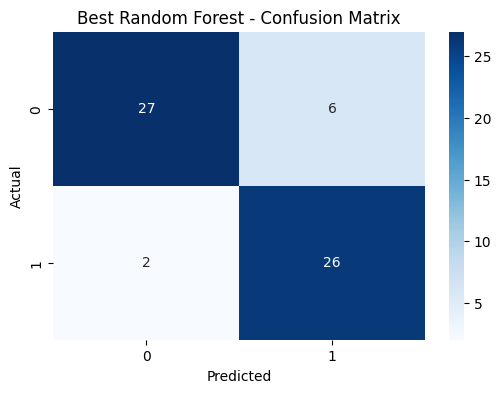

In [62]:
best_rf = grid_search_rf.best_estimator_
joblib.dump(best_rf, "/content/models/best_random_forest.pkl")

y_pred_rf = best_rf.predict(X_test_selected)
y_prob_rf = best_rf.predict_proba(X_test_selected)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print("\nRandom Forest Test ROC AUC:", roc_auc_rf)
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Best Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/plots/best_rf_confusion_matrix.png')
plt.show()

### 🔍 Performing RandomizedSearchCV on Logistic Regression


In [ ]:
y_train = y_train.values.ravel()

In [77]:
param_dist_lr = [
    # liblinear supports only l1 and l2
    {'penalty': ['l1', 'l2'], 'C': np.logspace(-2, 2, 20), 'solver': ['liblinear']},

    # lbfgs supports only l2 and None
    {'penalty': ['l2'], 'C': np.logspace(-2, 2, 20), 'solver': ['lbfgs']},

    # sag supports only l2
    {'penalty': ['l2'], 'C': np.logspace(-2, 2, 20), 'solver': ['sag']},

    # saga supports l1, l2, and elasticnet (elasticnet needs l1_ratio)
    {'penalty': ['l1', 'l2'], 'C': np.logspace(-2, 2, 20), 'solver': ['saga']},
    {'penalty': ['elasticnet'], 'C': np.logspace(-2, 2, 20), 'solver': ['saga'], 'l1_ratio': np.linspace(0, 1, 5)},
]


lr = LogisticRegression(max_iter=1000, random_state=42)
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist_lr,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    random_state=42,
    verbose=1
)

random_search_lr.fit(X_train_selected, y_train)

print("\n✅ Best Logistic Regression Parameters:")
print(random_search_lr.best_params_)
print(f"Best ROC AUC Score: {random_search_lr.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

✅ Best Logistic Regression Parameters:
{'solver': 'saga', 'penalty': 'l2', 'C': np.float64(0.18329807108324356)}
Best ROC AUC Score: 0.9017


### 📊 Evaluate and Save Best LR Model



Logistic Regression Test ROC AUC: 0.9632034632034633
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



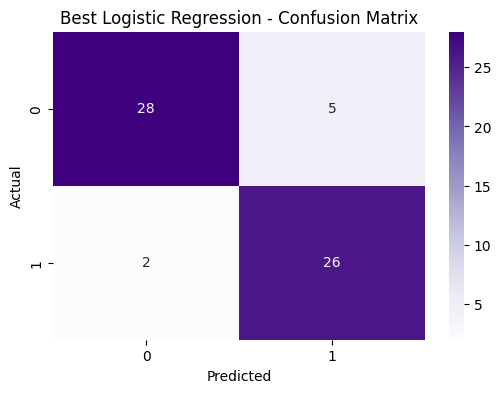

In [79]:
best_lr = random_search_lr.best_estimator_
joblib.dump(best_lr, "/content/models/best_logistic_regression.pkl")

y_pred_lr = best_lr.predict(X_test_selected)
y_prob_lr = best_lr.predict_proba(X_test_selected)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

print("\nLogistic Regression Test ROC AUC:", roc_auc_lr)
print(classification_report(y_test, y_pred_lr))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Purples')
plt.title('Best Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/plots/best_lr_confusion_matrix.png')
plt.show()

## 📈 6. ROC Curve Comparison

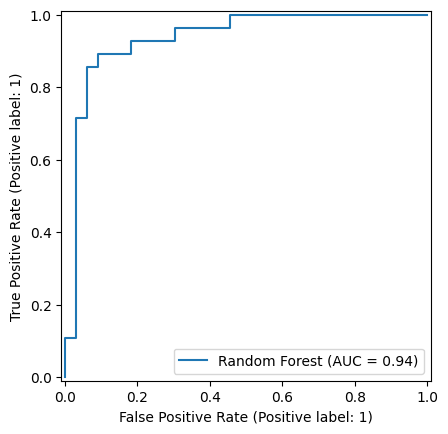

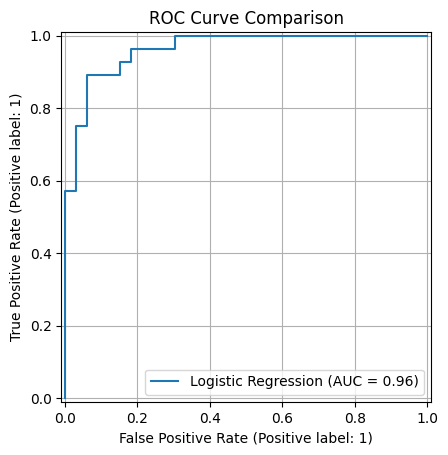

In [80]:
RocCurveDisplay.from_estimator(best_rf, X_test_selected, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(best_lr, X_test_selected, y_test, name="Logistic Regression")
plt.title("ROC Curve Comparison")
plt.grid()
plt.savefig("/content/plots/roc_curve_comparison.png")
plt.show()

## 🔍 7. SVM (Support Vector Machine) - Randomized Search


In [81]:
from sklearn.svm import SVC

print("🔍 Tuning SVM...")

param_dist_svm = {
    'C': np.logspace(-3, 3, 20),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

svm = SVC(probability=True, random_state=42)

random_search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist_svm,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    random_state=42,
    verbose=1
)

random_search_svm.fit(X_train_selected, y_train)

print("\n✅ Best SVM Parameters:")
print(random_search_svm.best_params_)
print(f"Best ROC AUC Score: {random_search_svm.best_score_:.4f}")


🔍 Tuning SVM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Best SVM Parameters:
{'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'C': np.float64(2.976351441631316)}
Best ROC AUC Score: 0.9019


### 📊 Evaluate and Save Best SVM Model



SVM Test ROC AUC: 0.9545454545454546
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.78      0.89      0.83        28

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



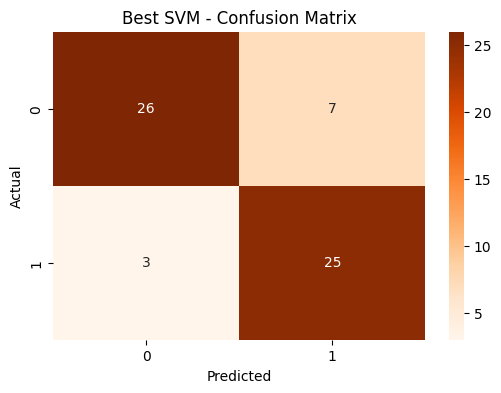

In [82]:
best_svm = random_search_svm.best_estimator_
joblib.dump(best_svm, "models/best_svm_model.pkl")

y_pred_svm = best_svm.predict(X_test_selected)
y_prob_svm = best_svm.predict_proba(X_test_selected)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

print("\nSVM Test ROC AUC:", roc_auc_svm)
print(classification_report(y_test, y_pred_svm))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Oranges')
plt.title('Best SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/best_svm_confusion_matrix.png')
plt.show()

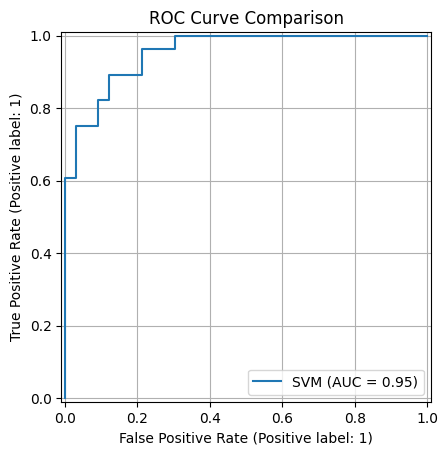

In [83]:
RocCurveDisplay.from_estimator(best_svm, X_test_selected, y_test, name="SVM")
plt.title("ROC Curve Comparison")
plt.grid()
plt.savefig("plots/roc_curve_comparison.png")
plt.show()